# Introduction

The application of Machine Learning (ML) to tabular data is one of the most popular tasks in the ML community because many areas (e.g., finance, medical) commonly use tabular data to store a set of information. The process of building an ML model for tabular data is often messy and less organized. This may intimidate newcomers in the ML community as the entire workflow seems to be vague and less-intuitive. Nevertheless, there are simply just 2 things that must be understood in order to build a good ML model for tabular data.:

1. How to perform a specific step? 
2. Which step should be performed first? 

The first one focuses on various techniques to achieve a specific step (for example, how to handle skewed features with log transformation), while the second refers to the entire workflow of building an ML model for a specific dataset. The second point is crucial as performing the wrong workflow is prone to serious issues (e.g., information leakage or degraded performance). However, the existing learning resources out there often show different workflows when applied to different tasks or a specific dataset, while mainly just repeating a similar pattern. Therefore, in this project, I attempt to establish the **same workflow** in a **jupyter notebook** that can be used to solve various predictive tasks, including classification and regression. I also demonstrate that the notebook I created is capable of achieving decent metric scores across different datasets.








---


>  Enjoy your journey. Explore sufficiently, stop when you are tired. Do not aim for a perfect model, decent one is enough.


---

Click on the `Table of contents` menu_icon_resized.png menu_icon.png icon on the top left toolbar to view the outline of overall steps.

TO-DO LIST

---


List of experiments :

1. 


Or 


Permutation the N number of experiments

==== Permutate with 2<sup>4</sup> number of permutation if possible ==== 

1. 

*As the baseline is obtained, it's a good idea to plan ahead the list of experiments to improve the baseline rather than mindlessly trying different experiments over and over again. With a plan in hand, it helps us track what has been done and what hasn't.* 




## step 1 : install all dependencies

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


## step 2 : import all libraries

In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

from collections import Counter
from numpy import percentile
from typing import Dict

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import precision_recall_fscore_support as scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## step 3 : store any utility function here.

In [59]:
def extract_missing_values_col_names(df):
  missing_val_col_names = []
  for col in tqdm(df.columns):
    if(df[col].isnull().any()):
      missing_val_col_names.append(col)

  return missing_val_col_names

def eval_class(model, X_train, X_test, y_train, y_test, plot_auc = False):
  train_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  prec_train, rec_train, f1_train, sup_train = scorer(y_train, train_predictions, average = 'macro')
  prec_test, rec_test, f1_test, sup_test = scorer(y_test, test_predictions, average = 'macro')
  
  data = {'train': [prec_train, rec_train, f1_train, sup_train], 
           'test': [prec_test, rec_test, f1_test, sup_test]}

  df = pd.DataFrame.from_dict(data, orient='index',
                      columns=['precision', 'recall', 'f1', 'support'])
 
  return df 

def eval_regres(model, x_train = None, 
         y_train = None, x_test = None,
         y_test = None, mse_squared = False):

    results = {'train' : [], 'test' : []}
    r2_train = []
    r2_test = []    
    
    mse_train = []
    mse_test = []

    mae_train = []
    mae_test = []

    mape_train = []
    mape_test = []

    y_pred_train = model.predict(x_train)
    r2_train.append(r2_score(y_train, y_pred_train))
    mse_train.append(mean_squared_error(y_train, y_pred_train, squared = mse_squared))
    mae_train.append(mean_absolute_error(y_train, y_pred_train))
    mape_train.append(mean_absolute_percentage_error(y_train, y_pred_train))

    y_pred_test = model.predict(x_test)
    r2_test.append(r2_score(y_test, y_pred_test))
    mse_test.append(mean_squared_error(y_test, y_pred_test, squared = mse_squared))
    mae_test.append(mean_absolute_error(y_test, y_pred_test))
    mape_test.append(mean_absolute_percentage_error(y_test, y_pred_test))

    results['train'].append(np.mean(r2_train))
    results['test'].append(np.mean(r2_test))

    results['train'].append(np.mean(mse_train))
    results['test'].append(np.mean(mse_test))

    results['train'].append(np.mean(mae_train))
    results['test'].append(np.mean(mae_test))

    results['train'].append(np.mean(mape_train))
    results['test'].append(np.mean(mape_test))    

    results_df = pd.DataFrame.from_dict(results, orient='index',
                        columns=['r2', 'rmse', 'mae', 'mape'])    


    return results_df  

def extract_multicolin_features(df, threshold = 0.75, plot = False):
  correlation_matrix = df.corr()

  if plot:
    plt.figure(figsize = (12, 10))
    sns.heatmap(correlation_matrix, annot = True, cmap="Greens")
    plt.show()
  
  highly_correlated_features = []
  
  for col_name, each_column in correlation_matrix.items():  
    
    for row_name, corr_value in each_column.items():                
      if col_name != row_name:      
        if abs(corr_value) >= threshold:
          highly_correlated_features.append(row_name)           
    
  return [*Counter(highly_correlated_features)], correlation_matrix


def identify_or_extract_outlier_indices_with_iqr(df, drop_outliers = False, 
                                                 impute_with_median = False,
                                                 extract_zero_outliers = False):
  outlier_sample_indices = []
  zero_outliers = []

  for feature_idx, feature_name in enumerate(df.columns):
    feature_distribution = df[feature_name]
    
    # calculate interquartile range
    q25, q75 = percentile(feature_distribution, 25), percentile(feature_distribution, 75)  
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off  
      
    # identify outliers
    num_of_outlier = 0
    for sample_idx, sample_val in enumerate(feature_distribution):
      # if indices hasn't been added yet 
      if sample_val < lower or sample_val > upper:
        num_of_outlier += 1

        # if impute with median
        if impute_with_median:
          # step 1 : calculate the median of that particular feature
          median = df[feature_name].median()
          # step 2 : impute the outlier with the median 
          df[feature_name][sample_idx] = median

        if sample_idx not in outlier_sample_indices:
          outlier_sample_indices.append(sample_idx)
    
    if extract_zero_outliers:
      if num_of_outlier == 0:        
        zero_outliers.append(feature_name)
    print(f"> feature [{feature_name}] has `{num_of_outlier}` outliers")
  
  print()
  print(f"Total outlier samples = {len(outlier_sample_indices)}")

  if drop_outliers and (impute_with_median is False):
    df.drop(df.index[outlier_sample_indices], inplace = True)

  return df, zero_outliers

## step 4 : load the dataset

In [64]:
data_path = '/content/Concrete_Data_Yeh.csv'
data = pd.read_csv(data_path)
print(data.shape)

(1030, 9)


## step 5 : take a peek on the subset of data

In [65]:
pd.set_option('display.max_columns', 500)
data.head(5)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## step 6 : drop useless features

What is considered as useless features?

> Well, there are no exact rules for a feature to be determined as useless. One way to identify useless features could be by reading through the "features description" (if provided) and compare the relevancy with the changes in target variable. This is done by simply using our common sense, nothing fancy. For example, in the case of Titanic ML competition, the features such as "passenger name" and "ticket number" might not be relevant to determine whether the passengers will survive or not from the Titanic shipwreck. Hence, we drop these features.


In [66]:
# ## every features are useful here

# data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

## step 7 : show data description

In [67]:
data.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## step 8 : categorical features encoding (optional)

### step 8.1 : count the unique values for each categorical features

This information is require to consider whether we will perform one-hot or label encoding. In the cases where we have many categorical features and most of them have a lot of unique values, it is better to perform label encoding compares to one-hot. This is because one-hot encoding increases the dimensionality of input features.



In [68]:
# categorical_features_name = ["fueltype", "aspiration", "doornumber","carbody", "drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"]
# for name in categorical_features_name:
#   print(f"{name} = {len(data[name].unique())}")

Define the list of features that later will be transformed into one-hot and label representation

In [69]:
# # one-hot 
# one_hot_features = ['drivewheel']

# # label
# label_features = ["fueltype", "aspiration", "doornumber","carbody","enginelocation", "enginetype", "cylindernumber", "fuelsystem"]

#### option 1 : one-hot encoding

for train set

In [70]:
# for name in one_hot_features:
#   # step 1 : perform one-hot encoding
#   one_hot_encoded = pd.get_dummies(data[name], prefix=name)

#   # step 2 : concat to the dataset
#   data = pd.concat([data, one_hot_encoded], axis = 1)

#   # step 3 : drop the original feature (before being transformed to one-hot)
#   data.drop([name], axis = 1, inplace = True)


# data.head()

for test set

In [71]:
# we don't have test set

#### option 2 : label encoding

In [72]:
# from sklearn import preprocessing 

# label_encoder = preprocessing.LabelEncoder() 

For train set

In [73]:
# for name in label_features:
#   data[name] = label_encoder.fit_transform(data[name]) 

# data.head()

For test set

In [74]:
# we don't have test set

## step 9 : split train data



---


The goal of splitting data is to generate 3 partition for the purpose of model development. The partition consist of:

*   Train set : used to train the model
*   Validation set : used to validate the trained model
*   Test set : used to test the final model



---

To split the data, </br>
1. If you have **a single file**, then: 
  *   First, split into 2 partition : (a) ~70% for **train** and (b) ~30% for **test**.
  *   Second, takes the **train set** from the previous splitted partition and split it again into another 2 partition with the same ratio : (a) ~70% for **train** and (b) ~30% for **validation**.

2. If you have **two files** (train, test), then:
  * Split the **train set** into 2 partition : (a) ~70% for **train** and (b) ~30% for **test**.
  
3. If you have **three files** (train, val, test), then:
  * You are good to go.



In [75]:
from sklearn.model_selection import train_test_split as data_splitter

train_data, test_data = data_splitter(data, 
                                    test_size = 0.2,
                                    random_state = 42)

In [76]:
train_data, val_data = data_splitter(train_data, 
                                    test_size = 0.2,
                                    random_state = 42)

In [77]:
print(f"len(train_data) = {len(train_data)}")
print(f"len(val_data) = {len(val_data)}")
print(f"len(test_data) = {len(test_data)}")

len(train_data) = 659
len(val_data) = 165
len(test_data) = 206


## step 10 : features visualization

### step 10.1 : identify outliers


#### option 1 : visualize outlier with boxplot

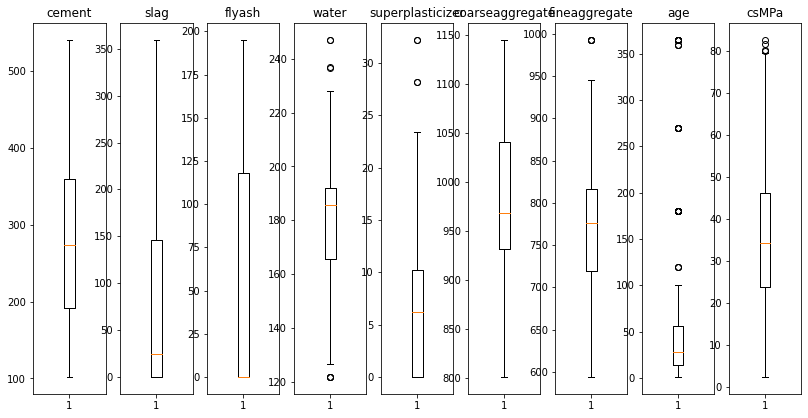

In [78]:
# Check for outliers
var=np.arange(1,len(train_data.columns)+1)

plt.figure(figsize = (20, 15))
for i in var:
    # plt.subplot(arg1, arg2) :
    # arg1 = the number of plots in each row
    # arg2 = the number of plots per column
    plt.subplot(2,13,i)
    plt.boxplot(train_data.iloc[:,(i-1)])
    plt.title(train_data.columns[i-1])

#### option 2 : identify outlier numerically using IQR (InterQuartile Range)

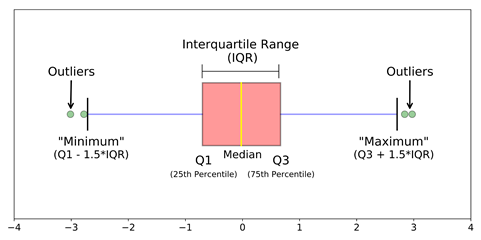

In [79]:
_, zero_outliers_features = identify_or_extract_outlier_indices_with_iqr(train_data, extract_zero_outliers = True)  

> feature [cement] has `0` outliers
> feature [slag] has `0` outliers
> feature [flyash] has `0` outliers
> feature [water] has `8` outliers
> feature [superplasticizer] has `4` outliers
> feature [coarseaggregate] has `0` outliers
> feature [fineaggregate] has `4` outliers
> feature [age] has `33` outliers
> feature [csMPa] has `4` outliers

Total outlier samples = 53


In [80]:
## we will normalize the features that doesn't contain outlier
print(zero_outliers_features)

['cement', 'slag', 'flyash', 'coarseaggregate']


### step 10.2 : normalize data (optional)

> Why we perform normalization in this step. This because according to this [reference](https://www.geeksforgeeks.org/normalization-vs-standardization/), normalization is useful when there are no outliers as it cannot cope up with them. That is why we decide to normalize after the outliers are identified.


*Also it is important to note that, data normalization or standardization step has to be performed after the process of data splitting. This is to prevent information leaking between each data partition.*


In [81]:
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = zero_outliers_features

**for train data**

In [82]:
## RESULT IS BETTER WITHOUT NORMALIZATION
# train_data[cols_to_norm] = MinMaxScaler().fit_transform(train_data[cols_to_norm])

In [83]:
# train_data.head()

**for validation data**

In [84]:
## RESULT IS BETTER WITHOUT NORMALIZATION
# val_data[cols_to_norm] = MinMaxScaler().fit_transform(val_data[cols_to_norm])

In [85]:
# val_data.head()

**for test data**

In [86]:
## RESULT IS BETTER WITHOUT NORMALIZATION
# test_data[cols_to_norm] = MinMaxScaler().fit_transform(test_data[cols_to_norm])

In [87]:
# test_data.head()

### step 10.3 : deal with outliers

#### Option 1 : Median imputation
Why **median** and not **mean**? 

> As the mean value is highly influenced by the outliers, it is advised to replace the outliers with the median value. ([reference](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)). In addition, this is also the reason why we deal with outlier first before handling missing values as the mean often used to impute them.

In [88]:
# train_data = identify_or_extract_outlier_indices_with_iqr(train_data, impute_with_median = True)  

##### Option 2 : Drop outlier sample

In [89]:
# train_data.drop(train_data.index[outlier_sample_indices], inplace=True)

### step 10.4 : visualize missing values

**for train data**

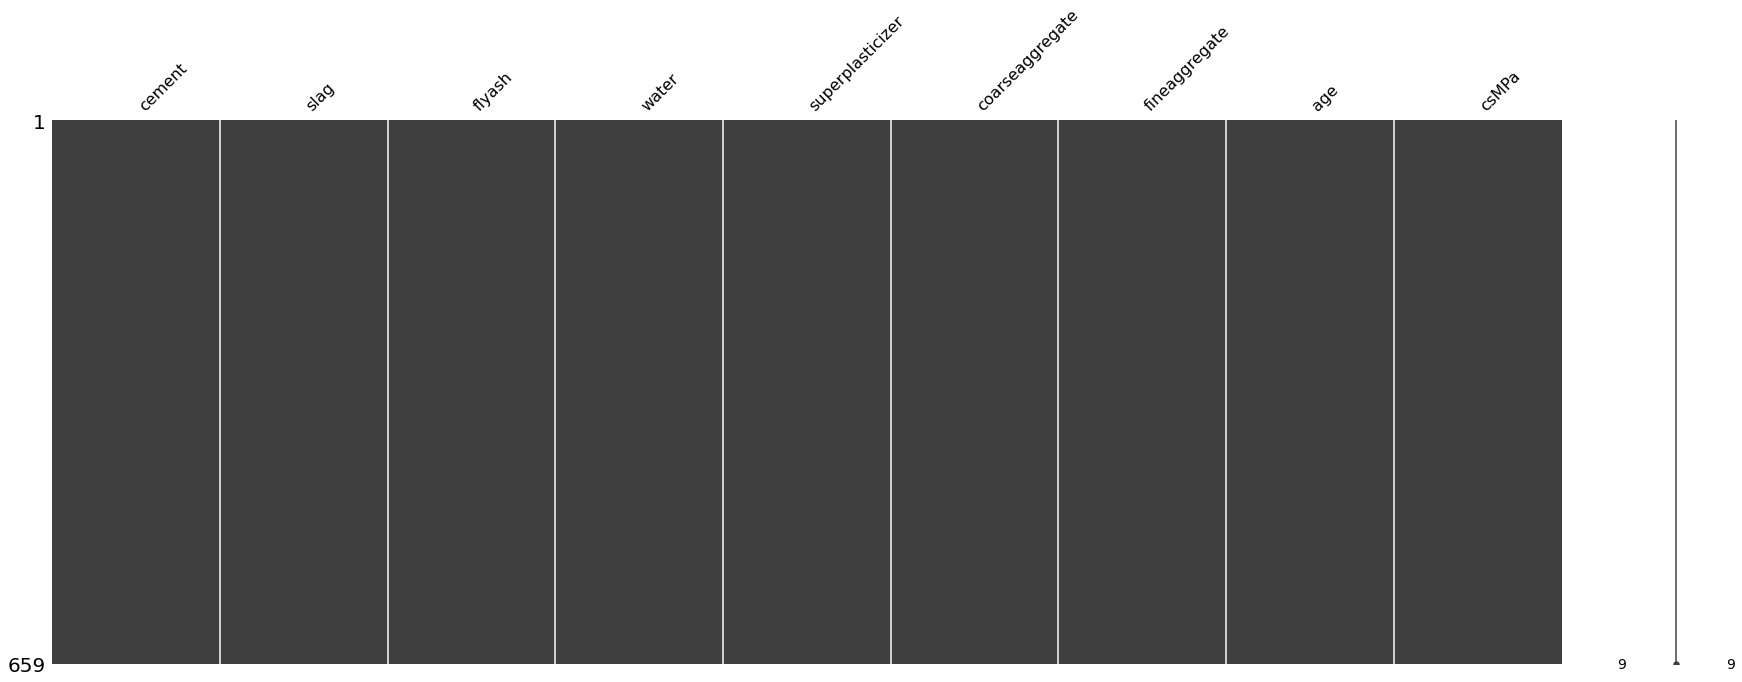

In [90]:
missingno.matrix(train_data, figsize = (30,10))

**for validation data**

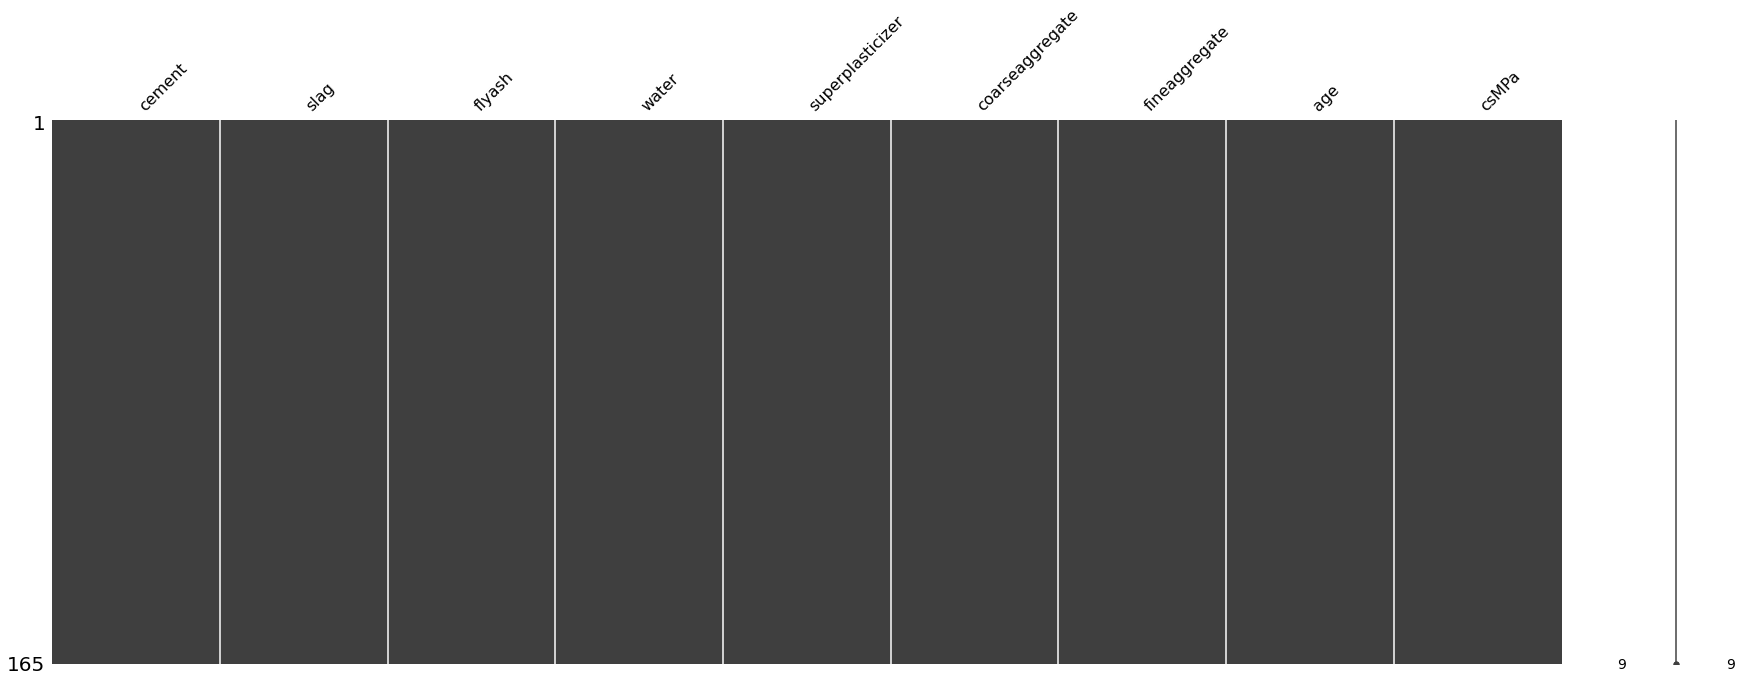

In [91]:
missingno.matrix(val_data, figsize = (30,10))

**for test data**

*It is important to note that in kaggle competition, the number of samples in the test set has to be preserved. Hence, we are not allowed to drop the sample that contains missing values as it will give an error during submission. So we need to impute them (e.g., mean, median) instead. However, in a real world scenario, imputing the test set will result in information leaking as we introduce the distribution of the entire test set. Thus, in real-world scenario, it is advised to drop the sample that contains missing values or apply batch normalization.*

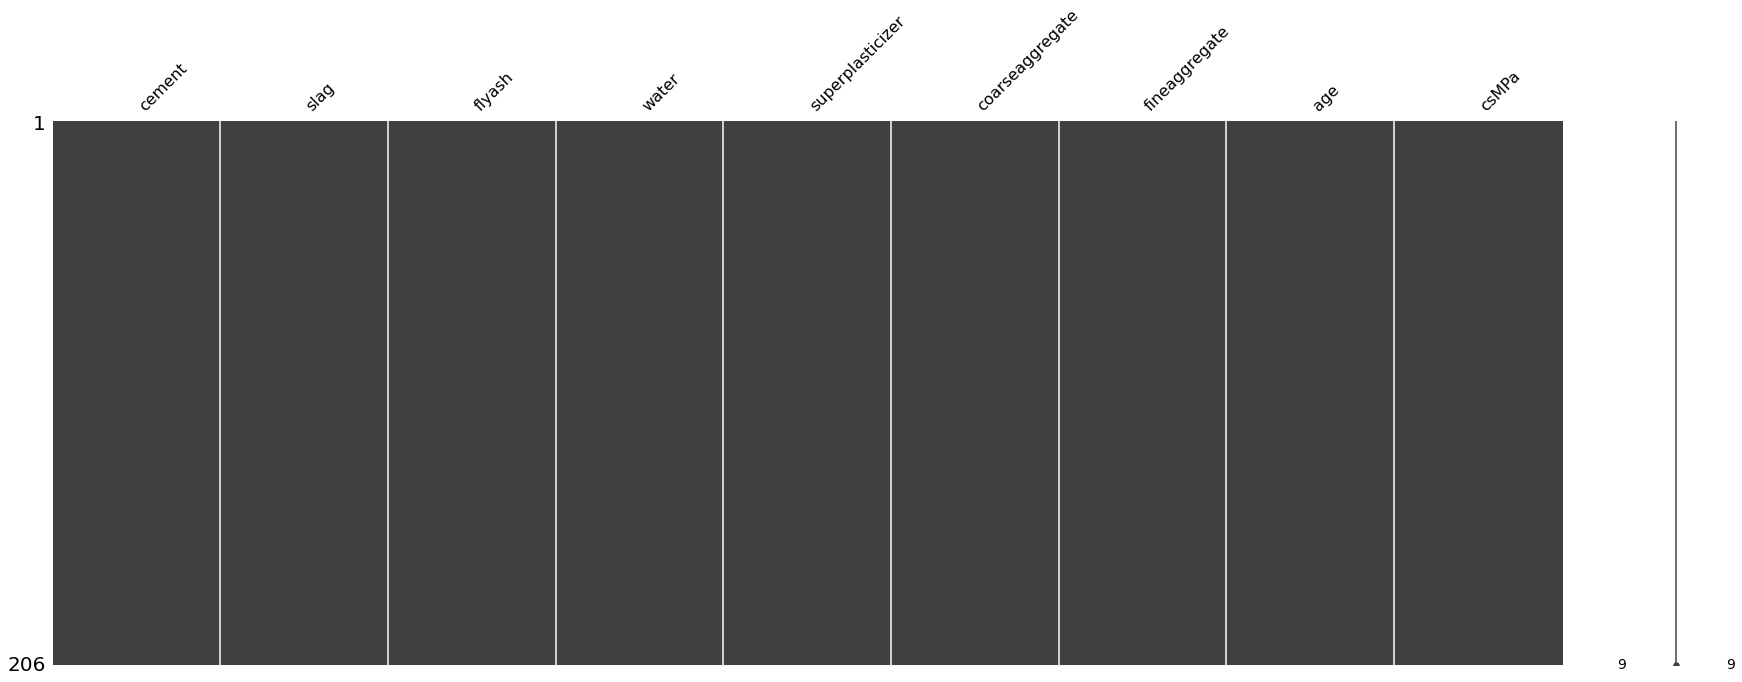

In [92]:
missingno.matrix(test_data, figsize = (30,10))

#### step 10.4.1 : describe missing values numerically.

In [93]:
# for col in test_data.columns:
# 	n_miss = test_data[col].isnull().sum()
# 	perc = (n_miss / len(test_data)) * 100
# 	print(f'col : {col} | Missing samples : {n_miss} | Missing perc : {perc}%')

##### 10.4.1.1 : deal with missing values (optional)

This is optional because some algorithm can handle missing values automatically. For example, LightGBM by specifying use_missing=false.

##### extract missing values columns name


In [94]:
# from tqdm.notebook import tqdm

# # step 1 : extract the column name in the test set that contain missing values
# train_data_missing_values_col_names = extract_missing_values_col_names(train_data)
# val_data_missing_values_col_names = extract_missing_values_col_names(val_data)
# test_data_missing_values_col_names = extract_missing_values_col_names(test_data)
# print(train_data_missing_values_col_names)
# print(val_data_missing_values_col_names)
# print(test_data_missing_values_col_names)

###### option 1 : impute with mean or median values

for train data

In [95]:
# for col_names in train_data_missing_values_col_names:
#   train_data[col_names].fillna(int(train_data[col_names].mean()), inplace=True)

for val data

In [96]:
# for col_names in val_data_missing_values_col_names:
#   val_data[col_names].fillna(int(val_data[col_names].mean()), inplace=True)

for test data

In [97]:
# for col_names in test_data_missing_values_col_names:
#   test_data[col_names].fillna(int(test_data[col_names].mean()), inplace=True)

###### option 2 : impute with mode (most frequent value)

###### option 3 : impute with knn classifier

In [98]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer()
# train_data = pd.DataFrame(imputer.fit_transform(train_data), columns = test_data.columns)

###### option 4 : drop the sample


*It is important to note that in kaggle competition, the number of samples in the test set has to be preserved. Hence, we are not allowed to drop the sample that contains missing values in this case as it will give an error during submission.*

In [99]:
# # step 1 : define feature name that has NA
# feature_name = 'Embarked'
# # step 2 : drop the sample (row) for train, val, test set
# train_data = train_data.dropna(subset=[feature_name])
# val_data = val_data.dropna(subset=[feature_name])
# test_data = test_data.dropna(subset=[feature_name])

### step 10.5 : visualize discrete features distribution

In [100]:
# step 1 : specify the discrete features name
discrete_features = ['age']

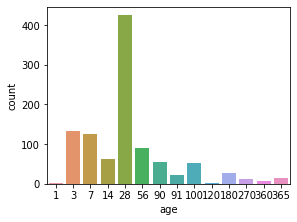

In [101]:
from IPython.core.pylabtools import figsize
figsize(20, 15)

for i, feature_name in enumerate(discrete_features):
    plt.subplot(4,4,i + 1)
    sns.countplot(data[feature_name])

#### step 10.5.1 : deal with skewed discrete features

### step 10.6 : visualize continuous features distribution

In [102]:
# step 1 : specify the continuous features name
continous_features = []
for name in data.columns:
  # features with prefix `drive` is discrete features that
  # transformed into one-hot 
  if (name not in discrete_features):
    continous_features.append(name)

In [103]:
len(continous_features)

8

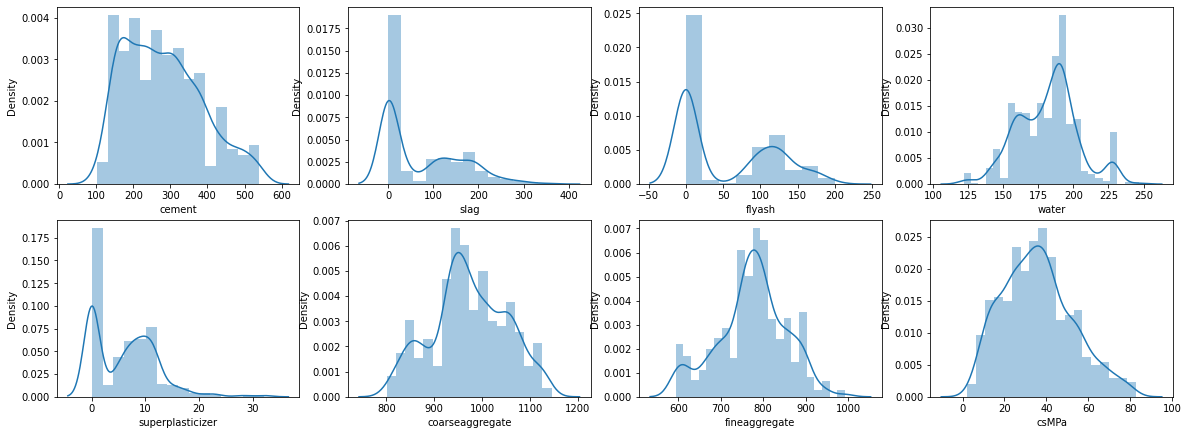

In [104]:
from IPython.core.pylabtools import figsize
figsize(20, 15)

for i, feature_name in enumerate(continous_features):
    plt.subplot(4,4,i + 1)
    sns.distplot(data[feature_name])

#### step 10.6.1 : deal with skewed continuous features

##### option 1 : log transformation

In [105]:
# train_data['Fare'] = np.log(train_data['Fare'] + 1)
# train_data['Fare'].skew()

In [106]:
# print(sns.displot(train_data.Fare))

### step 10.7 : visualize target class distribution

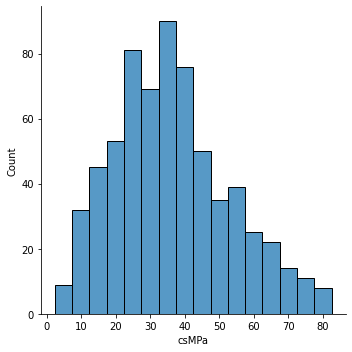

In [107]:
# # countplot for classification
# # (discrete and small number of classes)
# print(sns.countplot(train_data.insomnia).set_title("train data"))

# displot for regression
# (continous)
print(sns.displot(train_data.csMPa))

#### step 10.7.1 : deal with imblance class

**Oversampling** or **undersampling** techniques below doesn't guarantee for the model to perform better on minority class. Read more [here](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis).

##### option 1 : oversampling


In [108]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(train_data.drop(columns= ['Survived']), train_data['Survived'])

In [109]:
# X_df = pd.DataFrame(X, columns=train_data.drop(columns = ['Survived']).columns)
# y_df = pd.DataFrame(y, columns=['Survived'])

In [110]:
# # concatenate
# X_df['Survived'] = y_df['Survived']
# train_data_upsample = X_df

##### option 2 : undersampling

In [111]:
## add downsampling script

In [112]:
## visualize after performing up or down sampling
# print(sns.countplot(train_data_upsample.Survived).set_title("train data"))

### step 10.8 : visualize features correlation 

In this case, we are using `Pearson Correlation Matrix`. The `pearson correlation` measures the strength of the linear relationship between two variables. It has a value between -1 to 1, with a value of -1 meaning a total negative linear correlation, 0 being no correlation, and + 1 meaning a total positive correlation. The value greater than 0.5 has high correlation with the corresponding "pair of feature". (reference : [link](https://www.sciencedirect.com/topics/computer-science/pearson-correlation#:~:text=The%20Pearson%20correlation%20measures%20the,meaning%20a%20total%20positive%20correlation.))

>   Good examples of positive and negative correlation, [here](https://www.quora.com/What-are-some-good-positive-and-negative-correlation-examples).






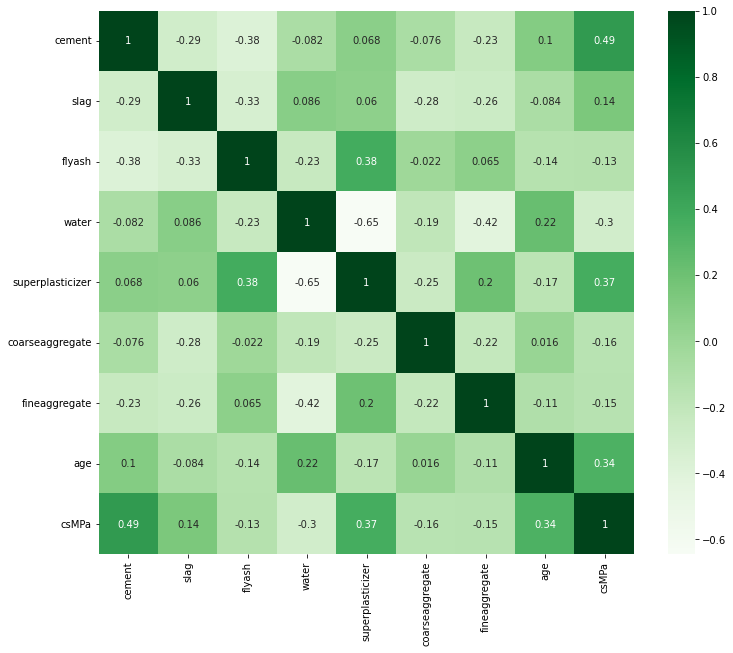

In [113]:
plt.figure(figsize = (12, 10))
sns.heatmap(train_data.corr(), annot = True, cmap="Greens")
plt.show()

#### step 10.8.1 : deal with multi-colinearity features

##### option 1 : drop the features `manually` 

In [114]:
# train_data_upsample.drop(columns = ['Fare'], inplace = True)
# val_data.drop(columns = ['Fare'], inplace = True)
# test_data.drop(columns = ['Fare'], inplace = True)

##### option 2 : drop the features `automatically` by specifying correlation value threshold.

In [115]:
# # step 1 : extract multi-colinearity features
# extracted_features, correlation_matrix = extract_multicolin_features(train_data, threshold = 0.4, plot = False)

# # step 2 : rank the extracted features based on the correlation with target value
# ranked_features = abs(correlation_matrix['Survived'][extracted_features])
# ranked_features = ranked_features.sort_values(ascending = False)

# # step 3 : remove all of the extracted features except the top feature
# top_feature = ranked_features.keys()[0]
# features_to_be_removed = list(ranked_features.drop(top_feature).keys())

# train_data.drop(columns = features_to_be_removed, inplace = True)
# val_data.drop(columns = features_to_be_removed, inplace = True)
# test_data.drop(columns = features_to_be_removed, inplace = True)

## step 11 : data modelling

### step 11.1 : define the input features and target variable

In [116]:
# before we start data modelling, let's start to define the x_train, y_train, x_val, y_val
x_train = train_data.drop(columns = 'csMPa')
x_val = val_data.drop(columns = 'csMPa')
x_test = test_data.drop(columns = 'csMPa')
y_train = train_data['csMPa']
y_val = val_data['csMPa']
y_test = test_data['csMPa']

### Regressor model

#### option 1 : linear regression (baseline) (optional)

In [117]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)

##### evaluate model 

In [118]:
eval_scores = eval_regres(reg, 
     x_train = x_train,
     y_train = y_train, 
     x_test = x_val,
     y_test = y_val,
     )
eval_scores

,r2,rmse,mae,mape
train,0.608186,10.555435,8.234396,0.314234
test,0.609647,10.471305,8.594685,0.348168


#### option 2 : Catboost regressor

In [119]:
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor

pipe = Pipeline([('poly', PolynomialFeatures(1)), 
                  ('scaler', StandardScaler()), 
                  ('cbr', CatBoostRegressor(silent=True, random_seed=13, loss_function='RMSE'))])

param_grid = {'cbr__iterations': [50, 100, 250], 
             'cbr__depth': [4, 5, 7, 8, 9],
              'cbr__l2_leaf_reg': [0.2, 0.5, 1, 3]
              }

catboost_regressor = GridSearchCV(pipe, param_grid, cv=5)
catboost_regressor.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                                       ('scaler', StandardScaler()),
                                       ('cbr',
                                        <catboost.core.CatBoostRegressor object at 0x7fbb9248c790>)]),
             param_grid={'cbr__depth': [4, 5, 7, 8, 9],
                         'cbr__iterations': [50, 100, 250],
                         'cbr__l2_leaf_reg': [0.2, 0.5, 1, 3]})

##### evaluate model 

In [120]:
eval_scores = eval_regres(catboost_regressor.best_estimator_, 
     x_train = x_train,
     y_train = y_train, 
     x_test = x_val,
     y_test = y_val,
     )
eval_scores

,r2,rmse,mae,mape
train,0.975504,2.639259,1.921965,0.064420
test,0.924056,4.618679,3.296052,0.115157


In [121]:
eval_scores = eval_regres(catboost_regressor.best_estimator_, 
     x_train = x_train,
     y_train = y_train, 
     x_test = x_test,
     y_test = y_test,
     )
eval_scores

,r2,rmse,mae,mape
train,0.975504,2.639259,1.921965,0.06442
test,0.898623,5.111031,3.646852,0.11516


### Classifier model

#### option 1 : Logistic Regression (baseline) (optional)

In [122]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# # step 1 : construct the pipeline
# pipe = Pipeline([('scaler', StandardScaler()),
#                  ('clf', LogisticRegression())])

# # step 2 : specify the model param to explore
# param_grid = [{'clf__C': [1, 10, 100, 1000]}]
# gs_logistic_regression = GridSearchCV(pipe, param_grid, cv=5)

# # step 3 : train the model
# gs_logistic_regression.fit(train_data.drop(columns='Survived'), train_data['Survived'])

# print(f"rfcModel.best_params = {gs_logistic_regression.best_params_}")

##### evaluate model 

In [123]:
# # step 4 : evaluate the model on validation data
# evaluation_data_log = eval_train_test(gs_logistic_regression.best_estimator_, 
#                                       train_data_upsample.drop(columns='Survived'), 
#                                       val_data.drop(columns='Survived'), 
#                                       train_data['Survived'], 
#                                       val_data['Survived'],)
# print(evaluation_data_log)

#### option 2 : Catboost classifier

In [124]:
# from sklearn.preprocessing import PolynomialFeatures
# from catboost import CatBoostClassifier

# pipe = Pipeline([('poly', PolynomialFeatures(1)), 
#                   ('scaler', StandardScaler()), 
#                   ('cbr', CatBoostClassifier(silent=True, random_seed=13, loss_function='Logloss'))])

# param_grid = {'cbr__iterations': [50, 100, 250], 
#              'cbr__depth': [4, 5, 7, 8, 9],}

# catboost_class = GridSearchCV(pipe, param_grid, cv=5)
# catboost_class.fit(train_data.drop(columns='csMPa'), train_data['csMPa'])

##### evaluate model 

In [125]:
# # step 3 : evaluate the scores on train and test set
# evaluation_data_log = eval_class(catboost_class.best_estimator_, 
#                                       train_data.drop(columns='csMPa'), 
#                                       val_data.drop(columns='csMPa'), 
#                                       train_data['csMPa'], 
#                                       val_data['csMPa'],)

# print(evaluation_data_log)

## step 12 : visualize features importance

The function used below to visualize `features importance` is copied from Daniel Bourke notebook [here](https://github.com/mrdbourke/your-first-kaggle-submission/blob/master/kaggle-titanic-dataset-example-submission-workflow.ipynb).

,imp,col
0,0.000000,cement
3,3.170471,water
6,4.217128,fineaggregate
5,6.373754,coarseaggregate
7,6.987081,age
2,8.967826,flyash
4,14.830858,superplasticizer
1,20.477571,slag
8,34.975311,csMPa


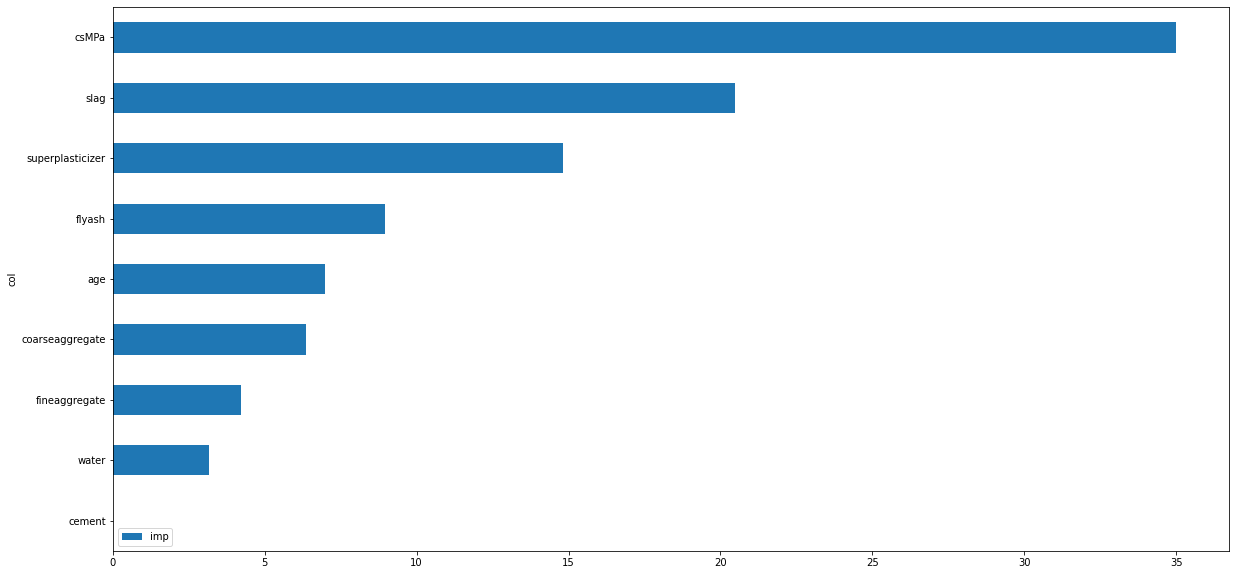

In [126]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

feature_importance(catboost_regressor.best_estimator_._final_estimator, train_data)

## step 13 : prepare for submission (optional)
if submit to kaggle

In [127]:
# # step 1 : intiliazie best model with the corresponding hyper-params
# best_model = catboost_class.best_estimator_

# predictions = best_model.predict(test_data)

# # # step 4 : retrieve the prediction probability (Optional)
# # total_probs = best_model.predict_proba(test_data)
# # probs = [total_probs[i, pred] for i, pred in enumerate(predictions)]

# # step 5 : load the submission file
# submission_path = '/content/gender_submission.csv' 
# submission = pd.read_csv(submission_path)

# # step 6 : fill the target with the prediction probability
# submission['Survived'] = predictions

# # step 7 : save the submission file
# save_path = '/content/prediction7.csv'
# submission.to_csv(save_path, index = False)

In [128]:
# submission.head(5)

# Conclusion

We achieve decent performance with MAPE (Mean Absolute Percentage Error) score around ~10 without performing an exhaustive features engineering. This is comparable with the stacked ensemble approache in this [work](https://www.kaggle.com/code/aryashah2k/predict-compressive-strength-stacked-ensemble) with the best score ~10. Other than that, I also found that, the scores is slightly better without normalization